In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import torch_harmonics as th
import torch
import numpy as np
import matplotlib as mpl
from datetime import datetime, timedelta
import cartopy.crs as ccrs

In [2]:
import xarray as xr
import glob

DATES = [
    "2020-01-06T00:00:00",
    "2020-01-13T00:00:00",
    "2020-01-20T00:00:00",
    "2020-01-27T00:00:00",
    "2020-02-03T00:00:00",
    "2020-02-10T00:00:00",
    "2020-02-17T00:00:00",
    "2020-02-24T00:00:00",
    "2020-03-02T00:00:00",
    "2020-03-09T00:00:00",
    "2020-03-16T00:00:00",
    "2020-03-23T00:00:00",
    "2020-03-30T00:00:00",
    "2020-04-06T00:00:00",
    "2020-04-13T00:00:00",
    "2020-04-20T00:00:00",
    "2020-04-27T00:00:00",
    "2020-05-04T00:00:00",
    "2020-05-11T00:00:00",
    "2020-05-18T00:00:00",
    "2020-05-25T00:00:00",
    "2020-06-01T00:00:00",
    "2020-06-08T00:00:00",
    "2020-06-15T00:00:00",
    "2020-06-22T00:00:00",
    "2020-06-29T00:00:00",
    "2020-07-06T00:00:00",
    "2020-07-13T00:00:00",
    "2020-07-20T00:00:00",
    "2020-07-27T00:00:00",
    "2020-08-03T00:00:00",
    "2020-08-10T00:00:00",
    "2020-08-17T00:00:00",
    "2020-08-24T00:00:00",
    "2020-08-31T00:00:00",
    "2020-09-07T00:00:00",
    "2020-09-14T00:00:00",
    "2020-09-21T00:00:00",
    "2020-09-28T00:00:00",
    "2020-10-05T00:00:00",
    "2020-10-12T00:00:00",
    "2020-10-19T00:00:00",
    "2020-10-26T00:00:00",
    "2020-11-02T00:00:00",
    "2020-11-09T00:00:00",
    "2020-11-16T00:00:00",
    "2020-11-23T00:00:00",
    "2020-11-30T00:00:00",
    "2020-12-14T00:00:00",]

def load_files(metric):
    # Define the base path
    base_path = "/pscratch/sd/a/amahesh/hens/time_collection/bred_29multicheckpoint_pert0p35_k1i3_500km_oppositepert_detfix_nodpr_timeevolve_hemisphererescale_target48_20minus20_newseed_repeat_qperturbfix_rankhist_qmin0_part2020/"
    
    subdirectories = [f"{base_path}/{date_str}" for date_str in DATES]

    # Initialize an empty list to store xarray datasets
    datasets = []

    # Iterate over each subdirectory
    for subdirectory in sorted(subdirectories):
        # Construct the full path to ensemble_mse.zarr within each subdirectory
        file_path = subdirectory + f"/{metric}.zarr"
        
        # Open the Zarr file as an xarray dataset
        dataset = xr.open_zarr(file_path, decode_times=False)
        # Append the dataset to the list of datasets
        datasets.append(dataset)

    # Concatenate all datasets along the time dimension
    return xr.concat(datasets, dim='initial_time')

sfno = load_files("ensemble")

In [3]:
sfno[['z500', 't250', 'u250', 'v250']].isel(ensemble=slice(0,4)).assign_coords(initial_time=DATES).to_netcdf("/global/cfs/cdirs/m4416/spectral_artifact/sample_ensemble_forecast.nc")

In [4]:
ifs_zarr = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-1440x721.zarr')
ifs_zarr = ifs_zarr.sel(time=DATES)
ifs_zarr = ifs_zarr.rename({'latitude' : 'lat',
                  'longitude' : 'lon'})

In [5]:
def calculate_spectrum(KE_500):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # calculate the spherical harmonic transform of KE_500
    ntime = len(KE_500.time)
    nlat = len(KE_500.lat)
    nlon = len(KE_500.lon)
    print(ntime)
    # initialize the scalar spherical harmonic transform
    sht = th.RealSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # initialize the vector spherical harmonic transform
    #vsht = th.RealVectorSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # initialize the spherical harmonic vector inverse transform
    #ivsht = th.InverseRealVectorSHT(nlat, nlon, grid = "equiangular").to(device).float()

    # calculate the SHT coefficients
    coeffs = sht(torch.from_numpy(KE_500.values).to(device))

    # normalize by Earth's surface area [m^2]
    r_earth = 6.371e6
    a_earth = 4*np.pi*r_earth**2
    
    # calculate the power spectrum
    # the SHT coefficient dimensions are (time, l, m)
    l_array = torch.arange(0, nlat, device = device)[None, :] * torch.ones(ntime, nlat, device = device)
    P_KE_500 = torch.real((2/(2*l_array + 1)) * torch.sum(coeffs * torch.conj(coeffs), dim = -1))

    l = np.arange(nlat)
    P_KE_500 = P_KE_500.numpy(force = True)

    # convert spherical harmonic degree to wavelength [km]
    lam = 2*np.pi*r_earth/(l + 1) / 1e3
    
    return lam, P_KE_500, ntime


49
49
49
49
49
49
49
49
49


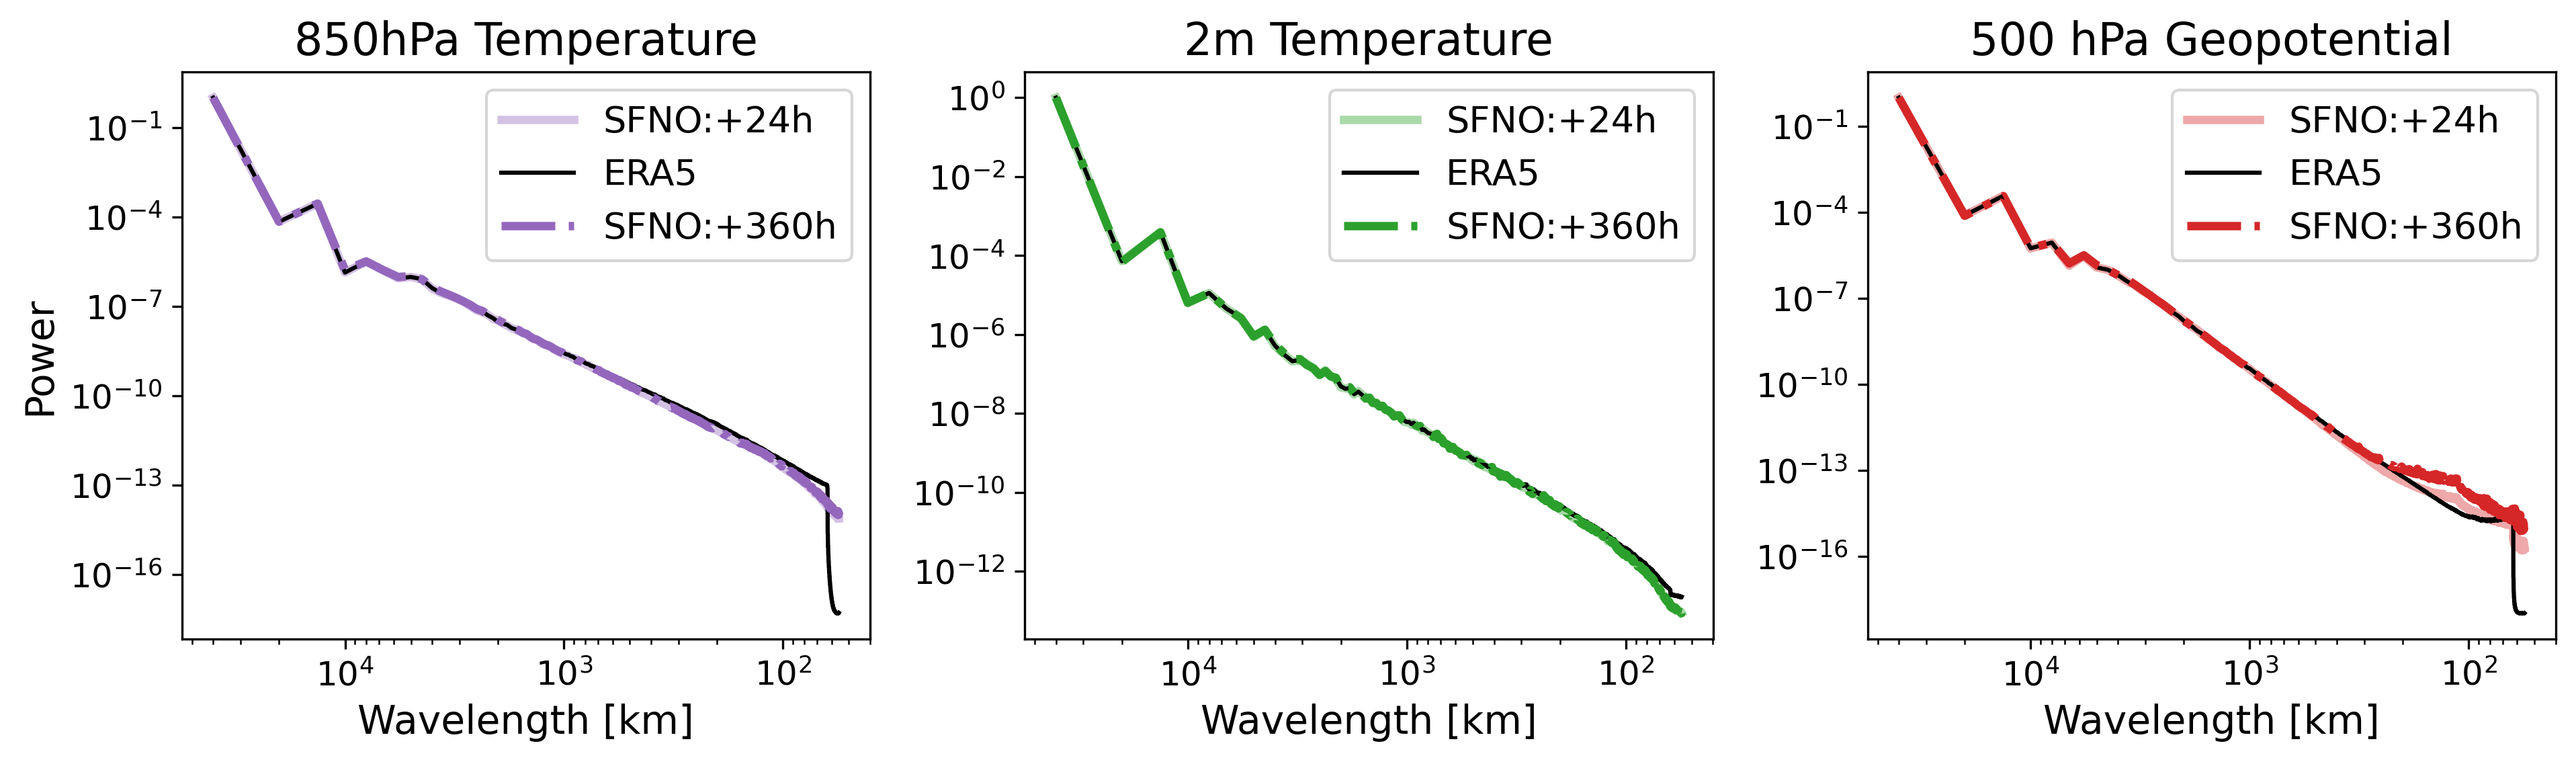

In [11]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

variables = ['t850', 't2m', 'z500']
fig, axes = plt.subplots(nrows=1, ncols=len(variables), figsize=(13, 4), dpi=300)

TITLE_MAP = {
    't850' : '850hPa Temperature',
    't2m' : '2m Temperature',
    'z500' : '500 hPa Geopotential',
    'u10m' : '10m U Wind',
        'q850' : '850 hPa Specific Humidity',
}

color_map_360h = {
    't2m' : 'C8',
    't850' : 'C6',
    'z500' : 'C1'
}

color_map_24h = {
    'q850': 'C0', 
    'u10m': 'C5', 
    'z500': 'C3', 
    't2m': 'C2',
    't850': 'C4'
}

for ax, variable in zip(axes, variables):
    lam_sfno, era5_spectrum, ntime = calculate_spectrum(sfno[variable].isel(ensemble=0, time=0, drop=True).rename({'initial_time': 'time'}))
    lam_sfno, sfno_spectrum, ntime = calculate_spectrum(sfno[variable].isel(ensemble=0, time=4, drop=True).rename({'initial_time': 'time'}))
    lam_sfno, sfno_spectrum_end, ntime = calculate_spectrum(sfno[variable].isel(ensemble=0, time=-1, drop=True).rename({'initial_time': 'time'}).load())

    ax.plot(lam_sfno, (sfno_spectrum / sfno_spectrum[:, 0:1]).mean(0), label='SFNO:+24h', linewidth=3, color=color_map_24h[variable], alpha=0.4)
    ax.plot(lam_sfno, (era5_spectrum / era5_spectrum[:, 0:1]).mean(0), label='ERA5', color='black')

    ax.plot(lam_sfno, (sfno_spectrum_end / sfno_spectrum_end[:, 0:1]).mean(0), color=color_map_24h[variable], label='SFNO:+360h', linestyle='-.',
            linewidth=3)

    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_title(TITLE_MAP[variable])
    ax.set_xlabel("Wavelength [km]")
    ax.legend()
    if ax == axes[0]:
        ax.set_ylabel("Power")
    # if variable == 'z500':
    #     ax.set_ylim((10**-14, 1))

plt.tight_layout()
plt.savefig("deterministic_spectra.pdf")
plt.show()


In [7]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 13
})

variables = ['t850', 't2m', 'z500']

TITLE_MAP = {
    't850' : '850hPa Temperature',
    't2m' : '2m Temperature',
    'z500' : '500 hPa Geopotential',
    'u10m' : '10m U Wind',
        'q850' : '850 hPa Specific Humidity',
}

color_map_360h = {
    't2m' : 'C8',
    't850' : 'C6',
    'z500' : 'C1'
}

color_map_24h = {
    'q850': 'C0', 
    'u10m': 'C5', 
    'z500': 'C3', 
    't2m': 'C2',
    't850': 'C4'
}



variable = 't850'
start_spectra = []
end_spectra = []
for member in range(0, 58):
    lam_sfno, sfno_spectrum, ntime = calculate_spectrum(sfno[variable].isel(ensemble=member, time=4, drop=True).rename({'initial_time': 'time'}))
    lam_sfno, sfno_spectrum_end, ntime = calculate_spectrum(sfno[variable].isel(ensemble=member, time=-1, drop=True).rename({'initial_time': 'time'}).load())
    start_spectra.append(sfno_spectrum)
    end_spectra.append(sfno_spectrum_end)
    print(member)



49
49
0
49
49
1
49
49
2
49
49
3
49
49
4
49
49
5
49
49
6
49
49
7
49
49
8
49
49
9
49
49
10
49
49
11
49
49
12
49
49
13
49
49
14
49
49
15
49
49
16
49
49
17
49
49
18
49
49
19
49
49
20
49
49
21
49
49
22
49
49
23
49
49
24
49
49
25
49
49
26
49
49
27
49
49
28
49
49
29
49
49
30
49
49
31
49
49
32
49
49
33
49
49
34
49
49
35
49
49
36
49
49
37
49
49
38
49
49
39
49
49
40
49
49
41
49
49
42
49
49
43
49
49
44
49
49
45
49
49
46
49
49
47
49
49
48
49
49
49
49
49
50
49
49
51
49
49
52
49
49
53
49
49
54
49
49
55
49
49
56
49
49
57


In [11]:
lam_sfno, era5_spectrum, ntime = calculate_spectrum(sfno['t850'].isel(ensemble=0,time=0,drop=True).rename({
        'initial_time' : 'time'}))

49


In [8]:
end_spectra = np.stack(end_spectra[1:], axis=1)

In [9]:
max_power = (end_spectra[:, :] / end_spectra[:,:, 0:1]).mean(0).max(0)
min_power = (end_spectra[:, :] / end_spectra[:,:, 0:1]).mean(0).min(0)

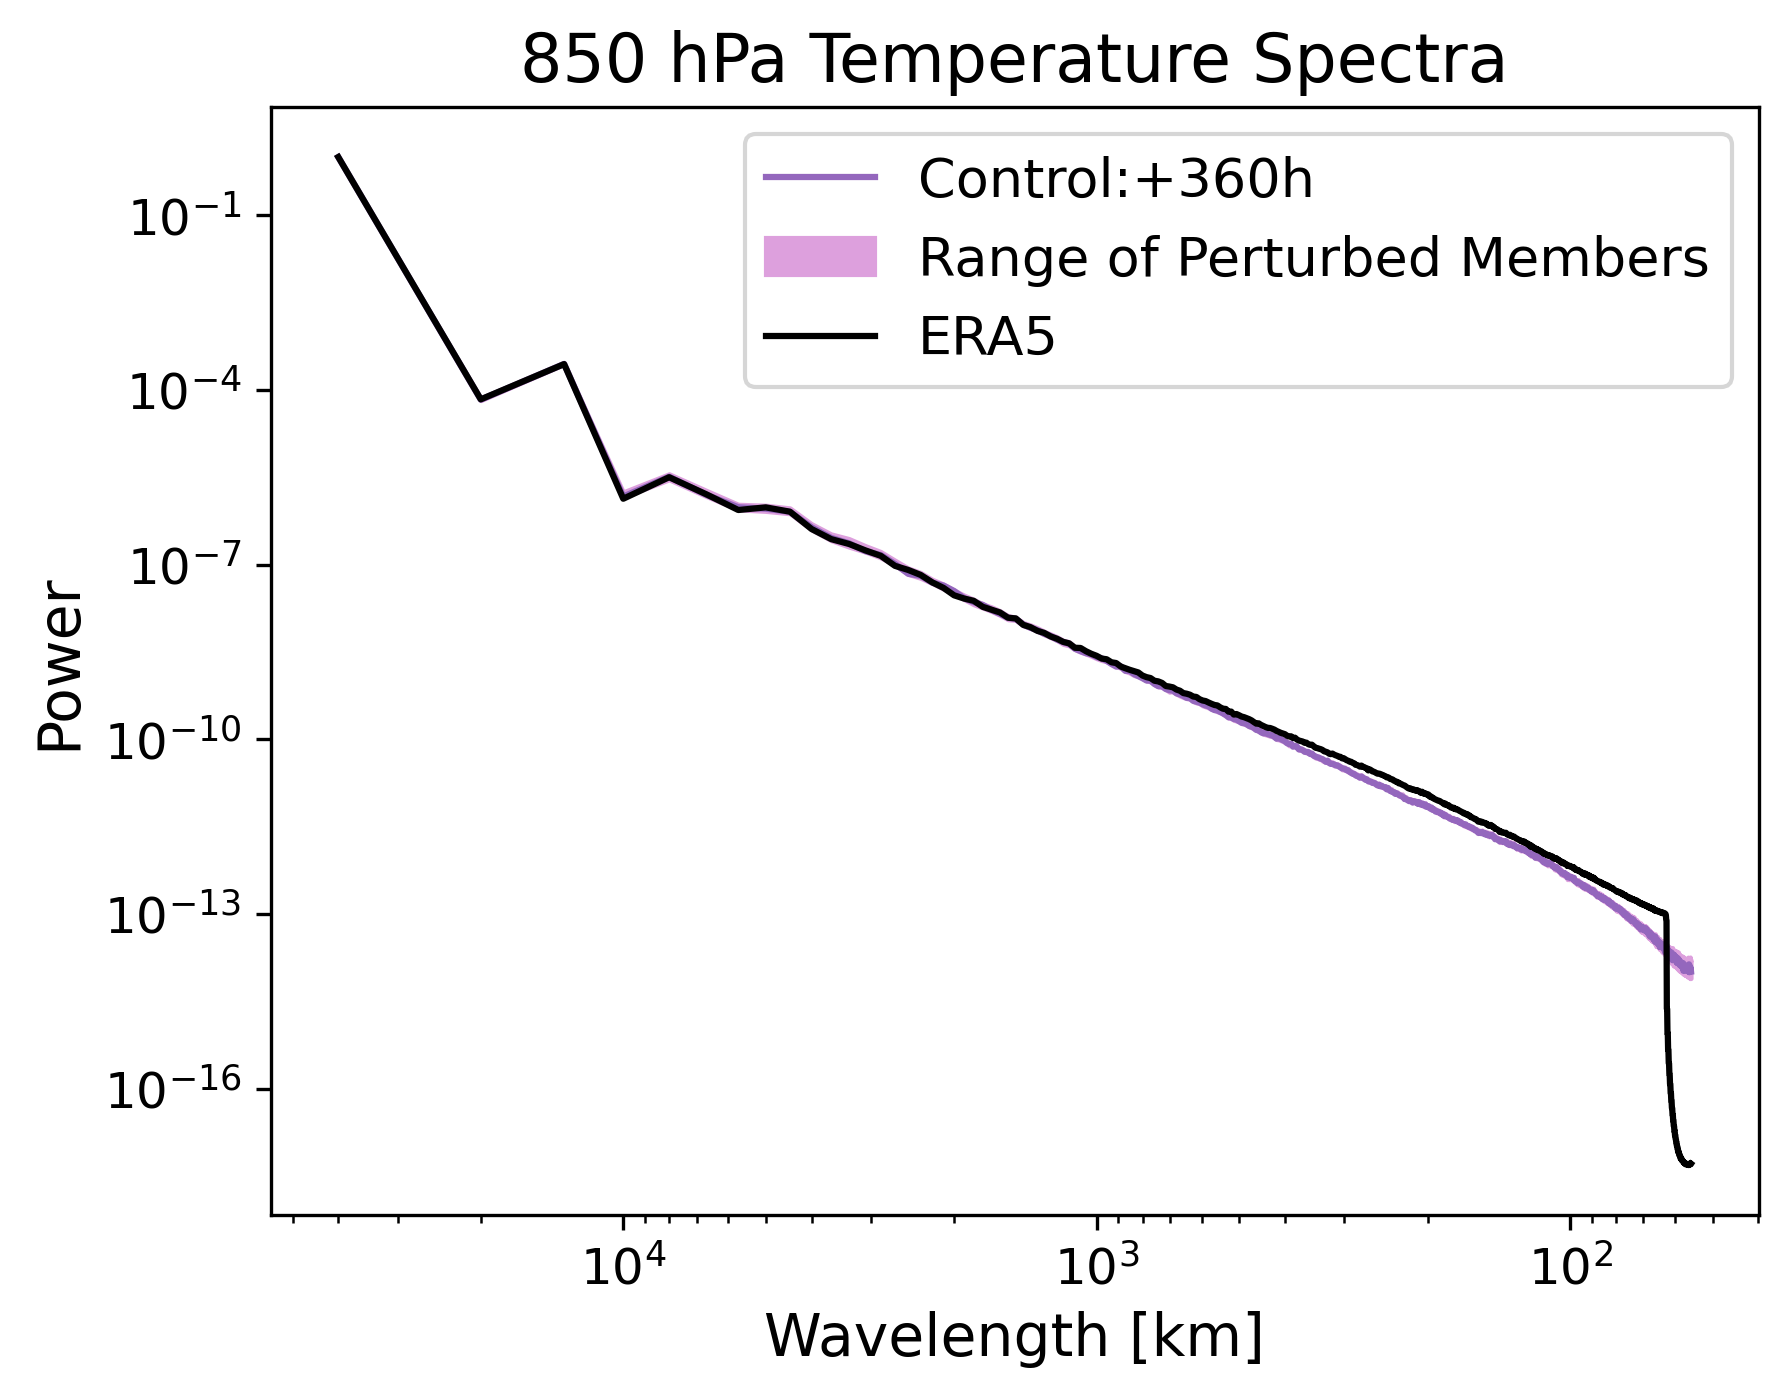

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1,  dpi=300)

# for i in range(1,58):
#     ax.plot(lam_sfno, (end_spectra[:, i] / end_spectra[:, i, 0:1]).mean(0), color='C4', alpha=0.1)

ax.plot(lam_sfno, (end_spectra[:, 0] / end_spectra[:, 0, 0:1]).mean(0), label='Control:+360h', color='C4')
ax.fill_between(lam_sfno, max_power, min_power, color='plum', 
               label='Range of Perturbed Members')
ax.plot(lam_sfno, (era5_spectrum / era5_spectrum[:, 0:1]).mean(0), label='ERA5', color='black')

ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])

ax.legend()
ax.set_ylabel("Power")
ax.set_title("850 hPa Temperature Spectra")
ax.set_xlabel("Wavelength [km]")
plt.savefig("bred_vector360h_spectra.pdf")
if variable == 'z500':
    ax.set_ylim((10**-15, 1))
